<a href="https://colab.research.google.com/github/Madhavi2075/OIB-SIP/blob/main/TASK_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
!pip install -q pandas scikit-learn matplotlib joblib


In [80]:
from google.colab import files
uploaded = files.upload()   # choose spam.csv when the file picker opens
file_name = list(uploaded.keys())[0]
print("Uploaded:", file_name)


Saving spam.csv to spam (2).csv
Uploaded: spam (2).csv


In [81]:
import pandas as pd
df = pd.read_csv(file_name, encoding='latin-1', low_memory=False)
print("Columns:", df.columns.tolist())
display(df.head())


Columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [82]:
# auto-detect label/text
label_col, text_col = None, None
if 'v1' in df.columns and 'v2' in df.columns:
    label_col, text_col = 'v1', 'v2'
else:
    for c in df.columns:
        if df[c].astype(str).str.contains('ham|spam', case=False).any():
            label_col = c
    object_cols = [c for c in df.columns if df[c].dtype == object]
    if object_cols:
        text_col = max(object_cols, key=lambda col: df[col].astype(str).map(len).median())

df = df[[label_col, text_col]].copy()
df.columns = ['label','text']
df.dropna(inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)
print("Using label:", label_col, "and text:", text_col)
print("Cleaned shape:", df.shape)


Using label: v1 and text: v2
Cleaned shape: (5169, 2)


In [83]:
import re
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\.\S+', ' url ', s)
    s = re.sub(r'\d+', ' number ', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['clean_text'] = df['text'].apply(clean_text)
display(df[['text','clean_text']].head())


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in number a wkly comp to win fa cup...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [84]:
df['label'] = df['label'].astype(str).str.lower().map(lambda x: 1 if 'spam' in x else 0)
df['label'].value_counts()


,count
label,
0,4516
1,653


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['clean_text'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(stop_words='english', max_features=8000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("Train shape:", X_train_tfidf.shape, "Test shape:", X_test_tfidf.shape)


Train shape: (4135, 8000) Test shape: (1034, 8000)


In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "MultinomialNB": MultinomialNB()
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    proba = model.predict_proba(X_test_tfidf)[:,1]
    results[name] = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, proba)
    }
    print(f"\n{name}")
    for k,v in results[name].items():
        print(f"  {k}: {v:.4f}")



LogisticRegression
  accuracy: 0.9691
  precision: 0.9231
  recall: 0.8244
  f1: 0.8710
  roc_auc: 0.9897

MultinomialNB
  accuracy: 0.9729
  precision: 1.0000
  recall: 0.7863
  f1: 0.8803
  roc_auc: 0.9908


Best model: MultinomialNB
Confusion matrix:
 [[903   0]
 [ 28 103]]


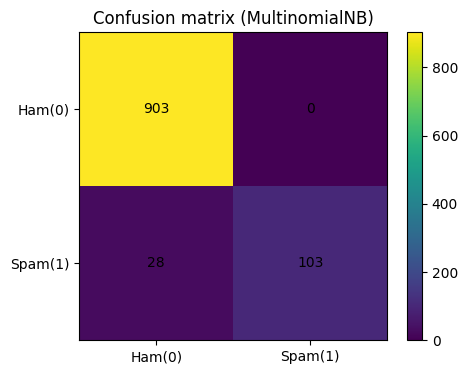

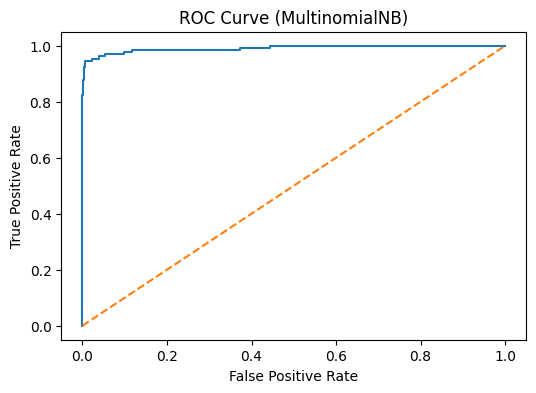

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve

# choose best by F1
best_name = max(results, key=lambda x: results[x]['f1'])
best_model = models[best_name]
print("Best model:", best_name)

y_pred = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# plot confusion matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title(f'Confusion matrix ({best_name})')
plt.colorbar()
plt.xticks([0,1], ['Ham(0)','Spam(1)'])
plt.yticks([0,1], ['Ham(0)','Spam(1)'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()

# ROC curve
y_proba = best_model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.title(f'ROC Curve ({best_name})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [88]:
import joblib
import os
out_dir = "spam_model_artifacts"
os.makedirs(out_dir, exist_ok=True)
joblib.dump(best_model, os.path.join(out_dir, "best_model.joblib"))
joblib.dump(vectorizer, os.path.join(out_dir, "tfidf_vectorizer.joblib"))
print("Artifacts saved to", out_dir)

# Sample predictions
samples = [
    "Congratulations! You've won a brand new car. Click here to claim.",
    "Hey, are we meeting for lunch tomorrow?",
    "Exclusive deal: buy two get one free — limited time!"
]
def clean_text_local(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\.\S+', ' url ', s)
    s = re.sub(r'\d+', ' number ', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    return re.sub(r'\s+',' ', s).strip()

samples_clean = [clean_text_local(s) for s in samples]
samples_vec = vectorizer.transform(samples_clean)
preds = best_model.predict(samples_vec)
probas = best_model.predict_proba(samples_vec)[:,1]
for t,p,pr in zip(samples, preds, probas):
    print(f"\nText: {t}\nPredicted spam: {p} (prob={pr:.3f})")


Artifacts saved to spam_model_artifacts

Text: Congratulations! You've won a brand new car. Click here to claim.
Predicted spam: 0 (prob=0.467)

Text: Hey, are we meeting for lunch tomorrow?
Predicted spam: 0 (prob=0.003)

Text: Exclusive deal: buy two get one free — limited time!
Predicted spam: 0 (prob=0.022)
